# Credit Card Delinquicy Risk


## Importing Libraries

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

#import libraries for model training
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE


Set up data source path and name

In [9]:
path = 'C:/Users/mozulkifli/Downloads/mydocs/Project/Data_Source/credit_card_default/'
file_name = 'train.csv'

Read csv file of data source

In [10]:
df = pd.read_csv(path + file_name)
df.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

## EDA

The data is imbalanced with 0 (non-default) being the majority class and 1 (default) being the minority class.

In [16]:
df.shape

(45528, 19)

In [13]:
df['credit_card_default'].value_counts()

credit_card_default
0    41831
1     3697
Name: count, dtype: int64

Checking for column with missing values

In [14]:
df.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64

In [17]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_percentage)

no_of_children          1.700053
owns_car                1.201458
no_of_days_employed     1.016957
yearly_debt_payments    0.208663
migrant_worker          0.191091
total_family_members    0.182305
credit_score            0.017572
dtype: float64


### Handling Missing values

Checking skewness via graph

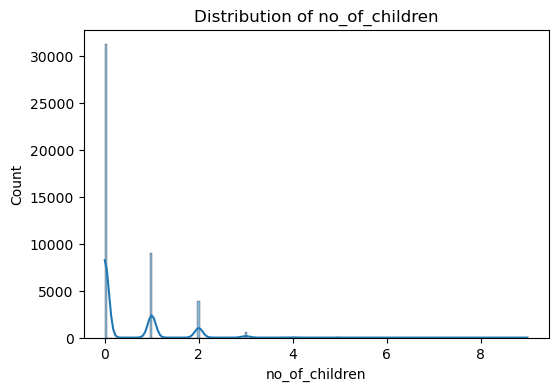

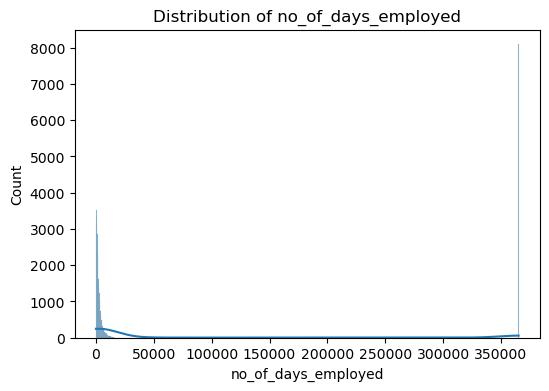

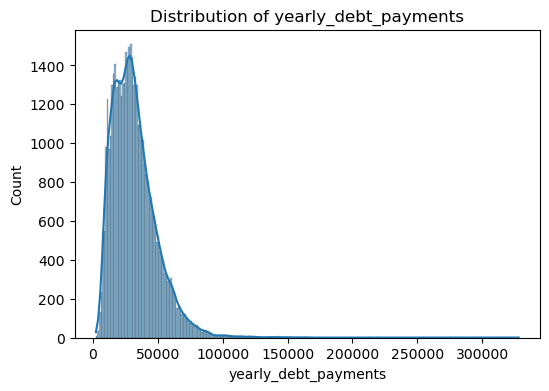

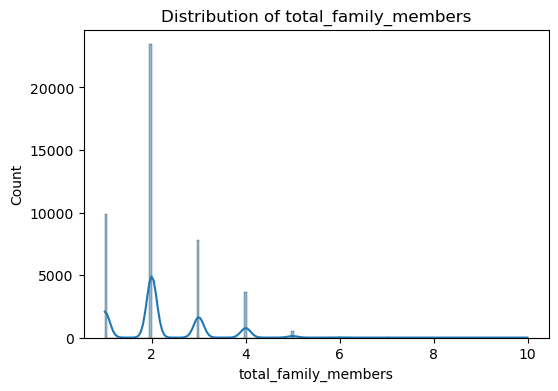

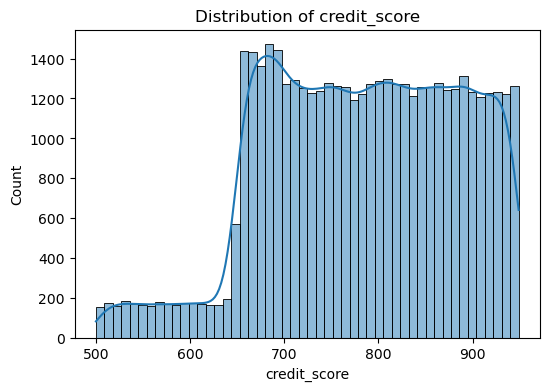

In [19]:
for col in ["no_of_children", "no_of_days_employed", "yearly_debt_payments", "total_family_members", "credit_score"]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Checking skewness numerically:
- If skew < |0.5| → mean is okay.
- If skew ≥ |0.5| → better use median.

In [21]:
df[["no_of_children", "no_of_days_employed", "yearly_debt_payments", 
    "total_family_members", "credit_score"]].skew()

no_of_children          1.827606
no_of_days_employed     1.667675
yearly_debt_payments    1.721201
total_family_members    0.924824
credit_score           -0.302517
dtype: float64

Imputing the missing values based on the skewness

In [22]:
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

df["credit_score"] = mean_imputer.fit_transform(df[["credit_score"]])

for col in ["no_of_children", "no_of_days_employed", "yearly_debt_payments", "total_family_members"]:
    df[col] = median_imputer.fit_transform(df[[col]])

In [23]:
df.isnull().sum()

customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children               0
net_yearly_income            0
no_of_days_employed          0
occupation_type              0
total_family_members         0
migrant_worker              87
yearly_debt_payments         0
credit_limit                 0
credit_limit_used(%)         0
credit_score                 0
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64

Categorical imputation:

In [29]:
cat_imputer = SimpleImputer(strategy="most_frequent")

for col in ["owns_car", "migrant_worker"]:
    df[col] = cat_imputer.fit_transform(df[[col]]).ravel()

In [30]:
df.isnull().sum()

customer_id                0
name                       0
age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
occupation_type            0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

No longer missing values

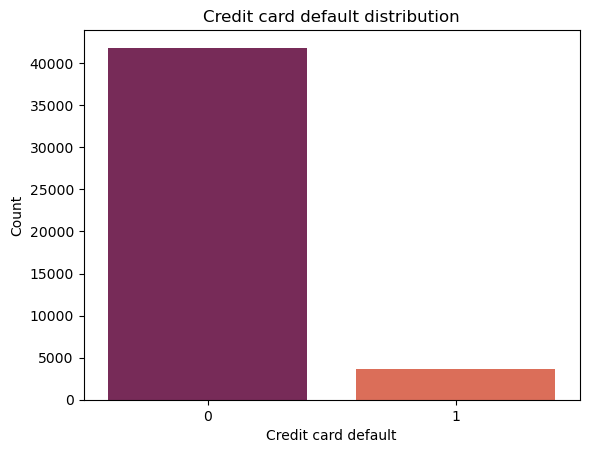

In [31]:
sns.countplot(data=df, x='credit_card_default', palette='rocket')
plt.xlabel('Credit card default')
plt.ylabel('Count')
plt.title('Credit card default distribution')
plt.show()

In [32]:
df.head(3)

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0


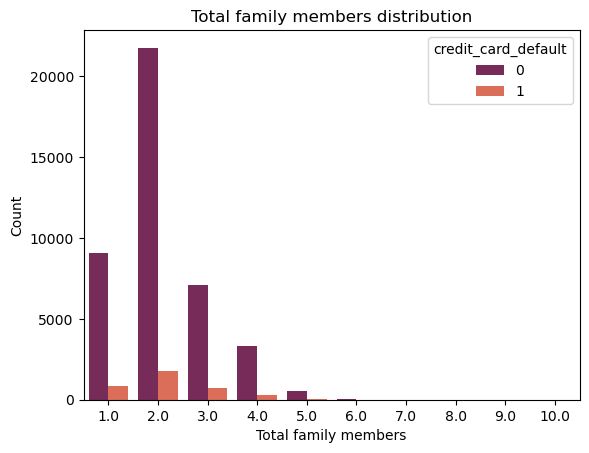

In [33]:
sns.countplot(data=df, x='total_family_members', hue='credit_card_default', palette='rocket')
plt.xlabel('Total family members')
plt.ylabel('Count')
plt.title('Total family members distribution')
plt.show()

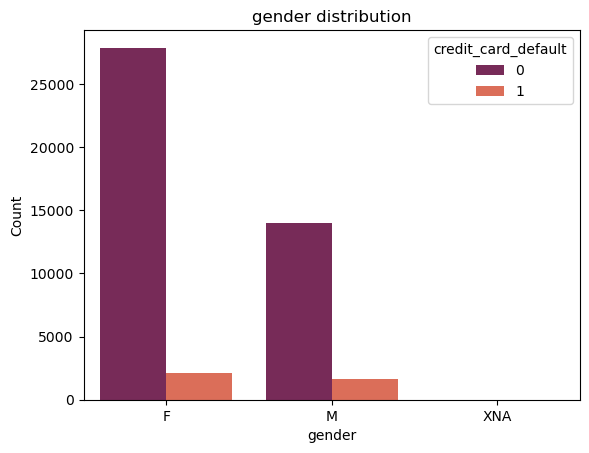

In [34]:
sns.countplot(data=df, x='gender', hue='credit_card_default', palette='rocket')
plt.xlabel('gender')
plt.ylabel('Count')
plt.title('gender distribution')
plt.show()

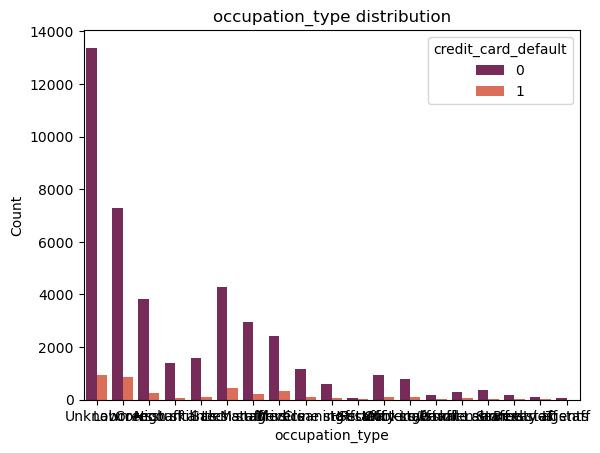

In [42]:
sns.countplot(data=df, x='occupation_type', hue='credit_card_default', palette='rocket')
plt.xlabel('occupation_type')
plt.ylabel('Count')
plt.title('occupation_type distribution')
plt.show()

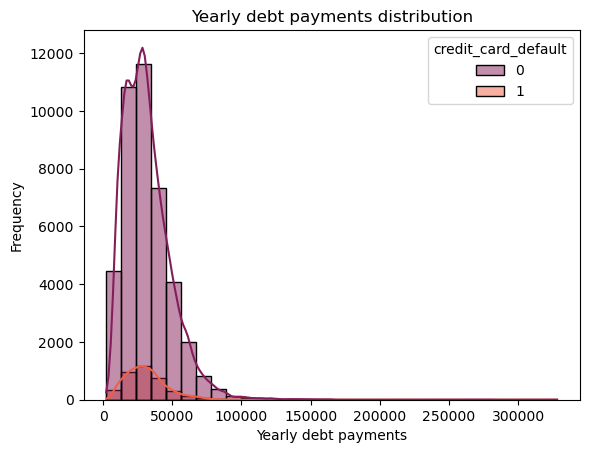

In [43]:
sns.histplot(data=df, kde=True, x='yearly_debt_payments', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Yearly debt payments')
plt.ylabel('Frequency')
plt.title('Yearly debt payments distribution')
plt.show()

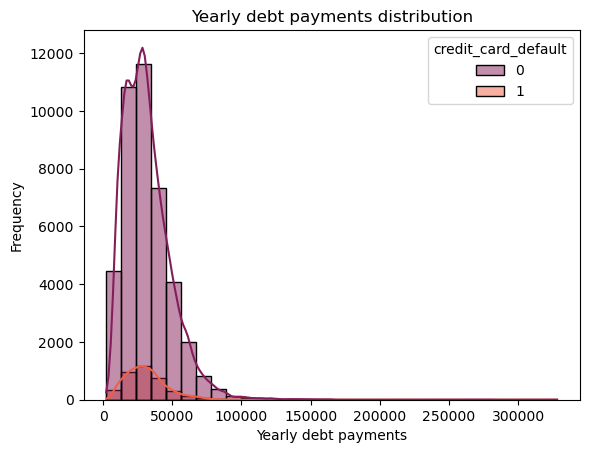

In [44]:
sns.histplot(data=df, kde=True, x='yearly_debt_payments', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Yearly debt payments')
plt.ylabel('Frequency')
plt.title('Yearly debt payments distribution')
plt.show()

In [45]:
'Skewness: %.2f'%(df['yearly_debt_payments'].skew())

'Skewness: 1.72'

In [40]:
mean_net_yearly_income_0 = df[df['credit_card_default']==0]['net_yearly_income'].mean()
mean_net_yearly_income_1 = df[df['credit_card_default']==1]['net_yearly_income'].mean()
median_net_yearly_income_0 = df[df['credit_card_default']==0]['net_yearly_income'].median()
median_net_yearly_income_1 = df[df['credit_card_default']==1]['net_yearly_income'].median()
print('Mean net yearly income 0: '+ str(mean_net_yearly_income_0))
print('Mean net yearly income 1: '+ str(mean_net_yearly_income_1))
print('Median net yearly income 0: '+ str(median_net_yearly_income_0))
print('Median net yearly income 1: '+ str(median_net_yearly_income_1))

Mean net yearly income 0: 198366.55366044323
Mean net yearly income 1: 226556.08969164186
Median net yearly income 0: 172065.18
Median net yearly income 1: 168195.13


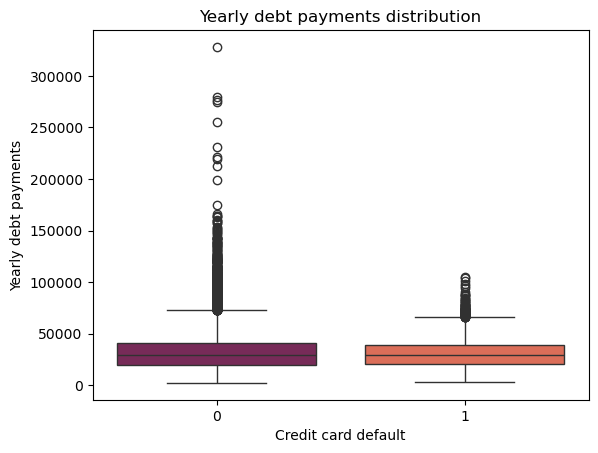

In [46]:
sns.boxplot(data=df, y='yearly_debt_payments', x='credit_card_default', palette='rocket')
plt.xlabel('Credit card default')
plt.ylabel('Yearly debt payments')
plt.title('Yearly debt payments distribution')
plt.show()

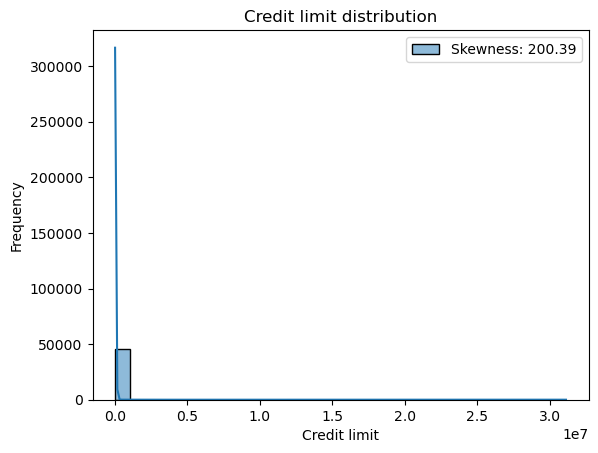

In [48]:
sns.histplot(data=df, kde=True, x='credit_limit', bins=30, palette='rocket', label = 'Skewness: %.2f'%(df['credit_limit'].skew()))
plt.xlabel('Credit limit')
plt.ylabel('Frequency')
plt.title('Credit limit distribution')
plt.legend()
plt.show()

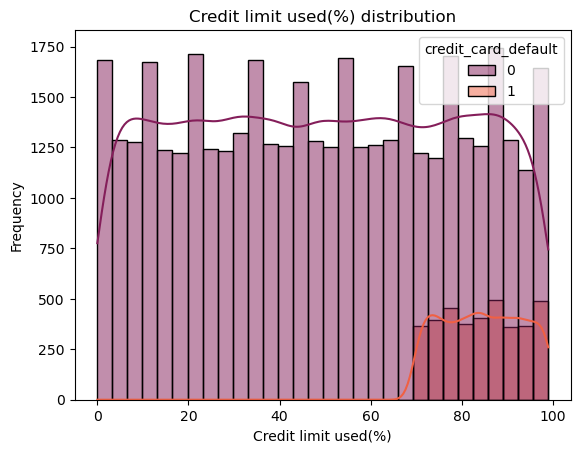

In [49]:
sns.histplot(data=df, kde=True, x='credit_limit_used(%)', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Credit limit used(%)')
plt.ylabel('Frequency')
plt.title('Credit limit used(%) distribution')
plt.show()

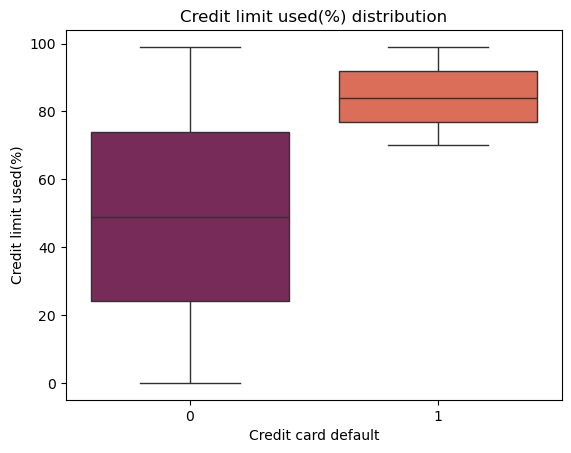

In [50]:
sns.boxplot(data=df, y='credit_limit_used(%)', x='credit_card_default', palette='rocket')
plt.xlabel('Credit card default')
plt.ylabel('Credit limit used(%)')
plt.title('Credit limit used(%) distribution')
plt.show()

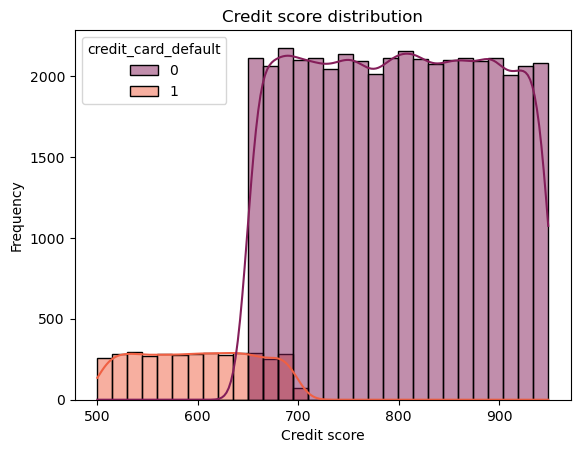

In [51]:
sns.histplot(data=df, kde=True, x='credit_score', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Credit score')
plt.ylabel('Frequency')
plt.title('Credit score distribution')
plt.show()

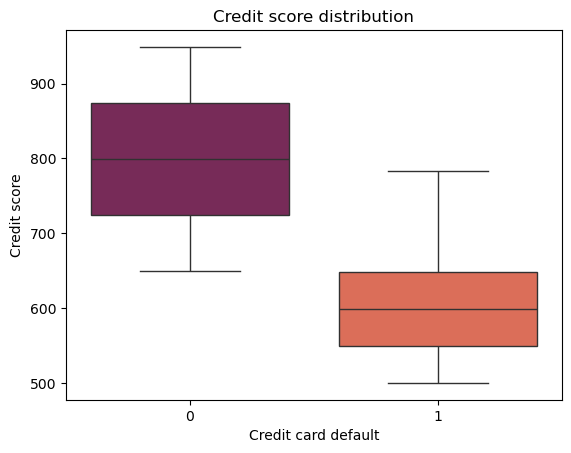

In [52]:
sns.boxplot(data=df, y='credit_score', x='credit_card_default', palette='rocket')
plt.xlabel('Credit card default')
plt.ylabel('Credit score')
plt.title('Credit score distribution')
plt.show()

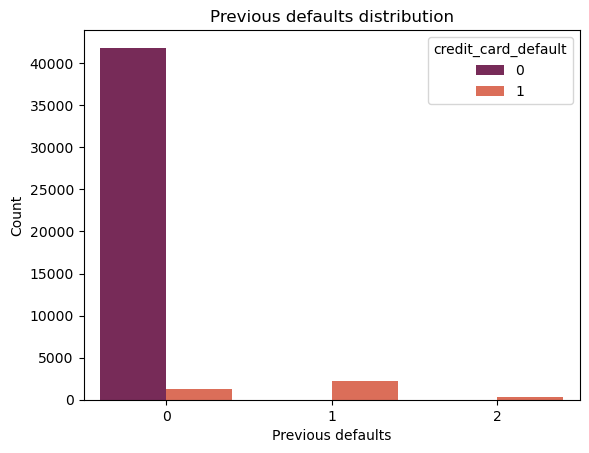

In [53]:
sns.countplot(data=df, x='prev_defaults', hue='credit_card_default', palette='rocket')
plt.xlabel('Previous defaults')
plt.ylabel('Count')
plt.title('Previous defaults distribution')
plt.show()

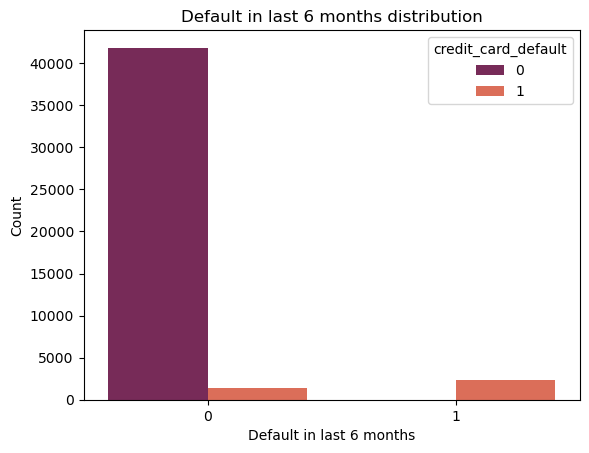

In [54]:
sns.countplot(data=df, x='default_in_last_6months', hue='credit_card_default', palette='rocket')
plt.xlabel('Default in last 6 months')
plt.ylabel('Count')
plt.title('Default in last 6 months distribution')
plt.show()

Log transformation of continuous variables

In [ ]:
df_log = df

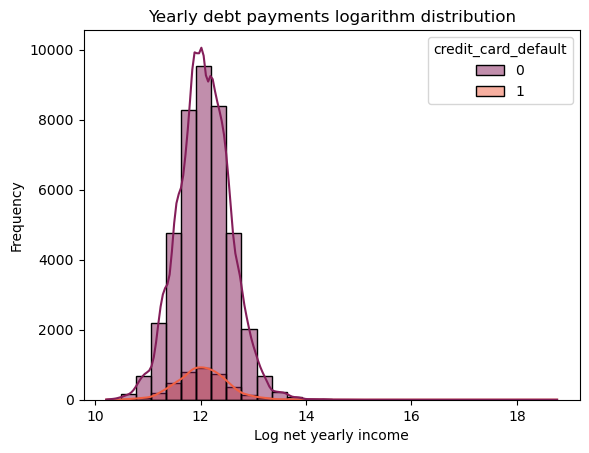

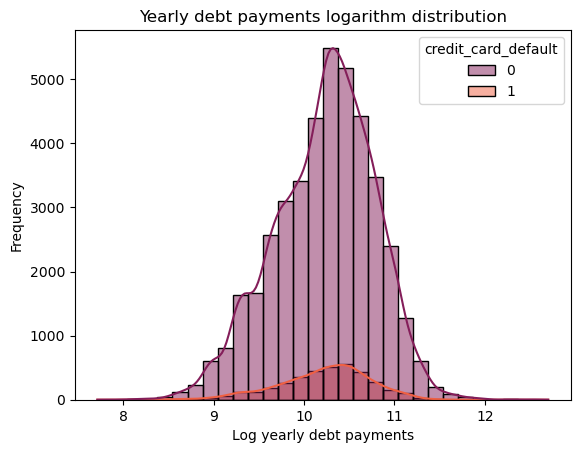

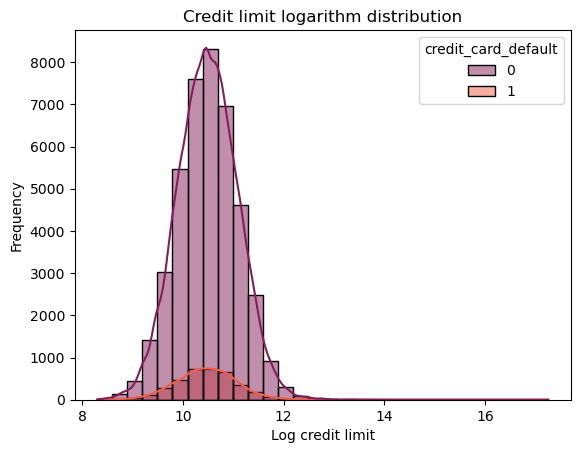

In [67]:
df_log['log_net_yearly_income'] = np.log(df_log['net_yearly_income'])
df_log['log_yearly_debt_payments'] = np.log(df_log['yearly_debt_payments'])
df_log['log_credit_limit'] = np.log(df_log['credit_limit'])

sns.histplot(data=df_log, kde=True, x='log_net_yearly_income', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Log net yearly income')
plt.ylabel('Frequency')
plt.title('Yearly debt payments logarithm distribution')
plt.show()

sns.histplot(data=df_log, kde=True, x='log_yearly_debt_payments', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Log yearly debt payments')
plt.ylabel('Frequency')
plt.title('Yearly debt payments logarithm distribution')
plt.show()

sns.histplot(data=df_log, kde=True, x='log_credit_limit', hue='credit_card_default', bins=30, palette='rocket')
plt.xlabel('Log credit limit')
plt.ylabel('Frequency')
plt.title('Credit limit logarithm distribution')
plt.show()

Encoding categorical features

In [68]:
cat_cols = ['gender', 'owns_car', 'owns_house', 'occupation_type', 'migrant_worker', 'default_in_last_6months']

In [69]:
enc = OrdinalEncoder()

enc.fit(df_log[cat_cols])
df_log[cat_cols] = enc.transform(df_log[cat_cols])

Correlation heatmap

In [72]:
df_log.head(2)

,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,...,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,log_net_yearly_income,log_yearly_debt_payments,log_credit_limit
0,ita Bose,46,0.0,0.0,1.0,0.0,107934.04,612.0,17.0,1.0,...,33070.28,18690.93,73,544.0,2,1.0,1,11.589276,10.406390,9.835794
1,Alper Jonathan,29,1.0,0.0,1.0,0.0,109862.62,2771.0,8.0,2.0,...,15329.53,37745.19,52,857.0,0,0.0,0,11.606986,9.637536,10.538613


In [74]:
df_log.drop(columns=['name'], inplace=True)

<Axes: >

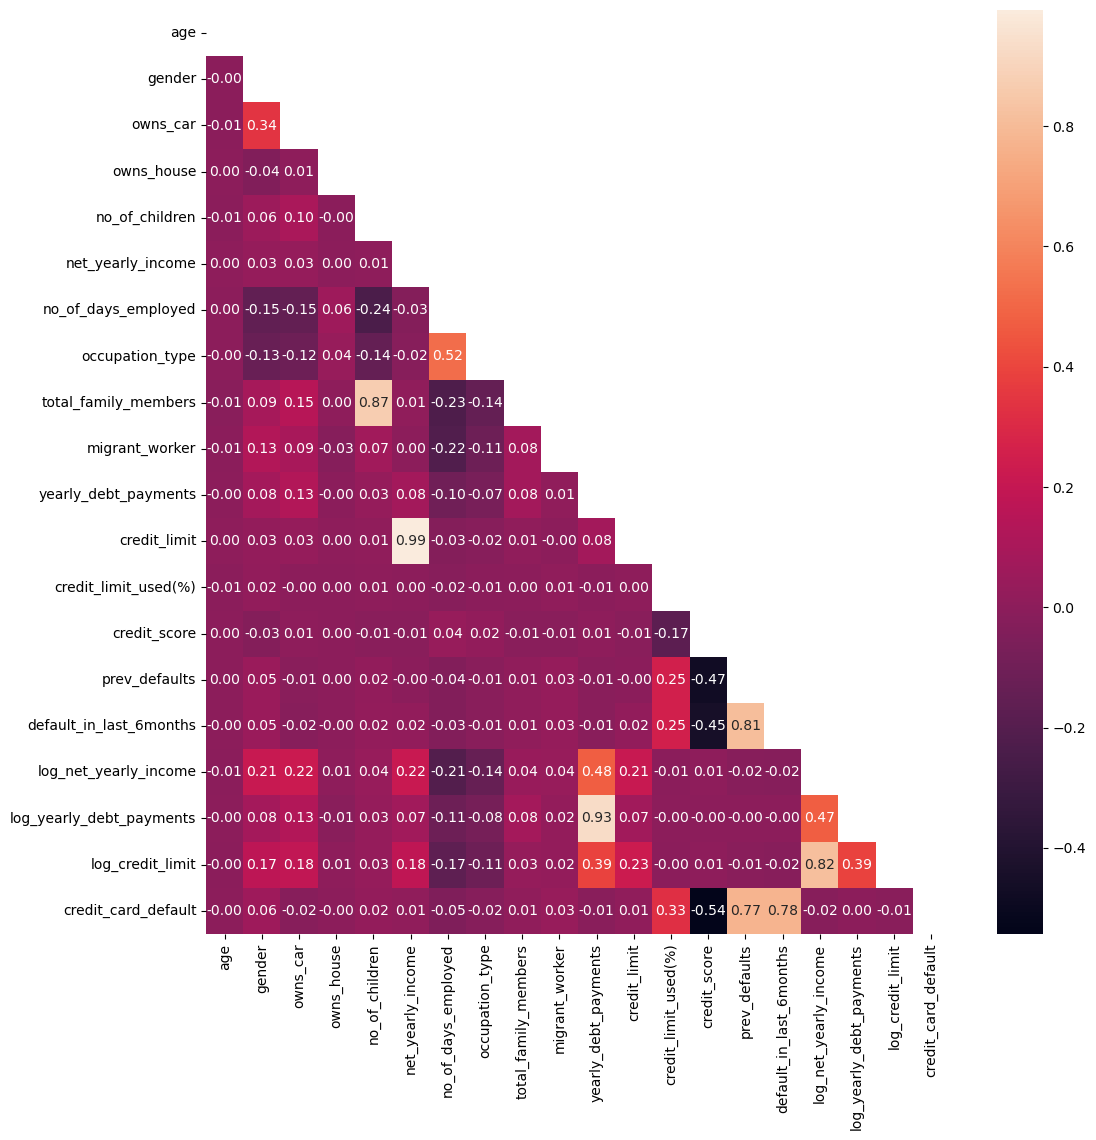

In [75]:
other_columns = [col for col in df_log.columns if col != 'credit_card_default']

desired_columns = other_columns + ['credit_card_default']
df_log = df_log[desired_columns]

corr_matrix = df_log.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f')

## Modeling

In [76]:
train_features = ['credit_limit_used(%)', 'credit_score', 'default_in_last_6months']

X = df_log[train_features]
y = df_log['credit_card_default']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = [accuracy_score, precision_score, recall_score, f1_score, confusion_matrix]

def model_training(model):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def evaluate(preds, metrics):
    scores = []
    for metric in metrics:
        scores.append(metric(preds, y_test))
    conf_matrix = confusion_matrix(preds, y_test)
    return scores, conf_matrix

def plot_evaluation(scores, conf_matrix):
    print('Accuracy: '+str(scores[0]))
    print('Precision: '+str(scores[1]))
    print('Recall: '+str(scores[2]))
    print('F1 Score: '+str(scores[3]))
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_matrix, annot=labels, fmt='')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [95]:
# Results list
results = []

# Evaluation helper
def evaluate_model(name, pipeline):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })


KNN

Accuracy: 0.9780364594772677
Precision: 0.7846952010376135
Recall: 0.94679186228482
F1 Score: 0.8581560283687943


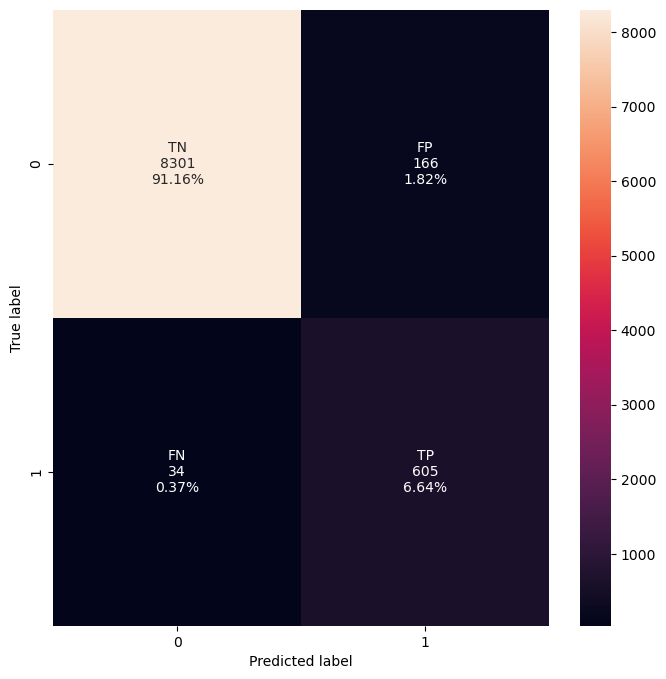

In [96]:
preds = model_training(KNeighborsClassifier(n_neighbors=4))
scores, conf_matrix = evaluate(preds, metrics)
plot_evaluation(scores, conf_matrix)

knn_pipeline = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", KNeighborsClassifier(n_neighbors=4))
])

# Evaluate and append to results
evaluate_model("KNN (k=4)", knn_pipeline)

Logistic regression

Accuracy: 0.9801229958269273
Precision: 0.7963683527885862
Recall: 0.9623824451410659
F1 Score: 0.8715400993612491


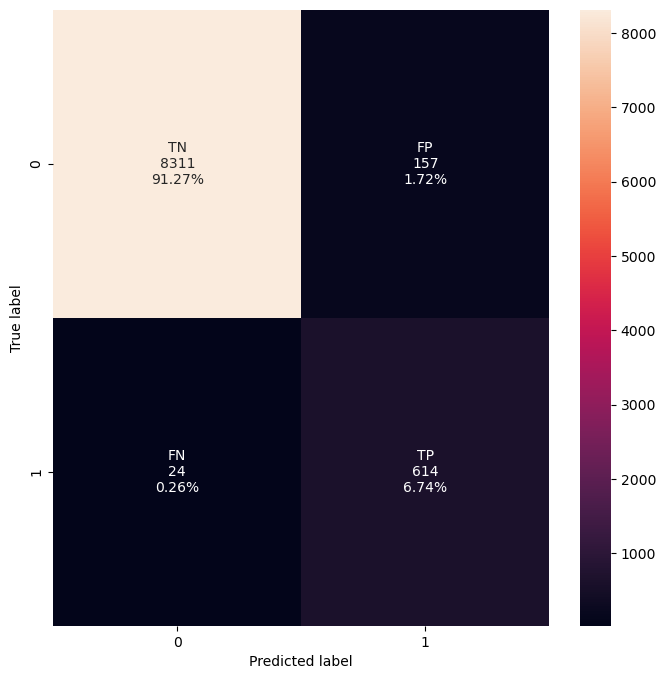

In [97]:
preds = model_training(LogisticRegression(random_state=42))
scores, conf_matrix = evaluate(preds, metrics)
plot_evaluation(scores, conf_matrix)

logreg_pipeline = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", LogisticRegression(
        random_state=42,
        max_iter=500,
        class_weight="balanced"
    ))
])

# Evaluate and append results
evaluate_model("Logistic Regression", logreg_pipeline)

Decision Tree

Accuracy: 0.9748517461014715
Precision: 0.8158236057068742
Recall: 0.8784916201117319
F1 Score: 0.8459986550100874


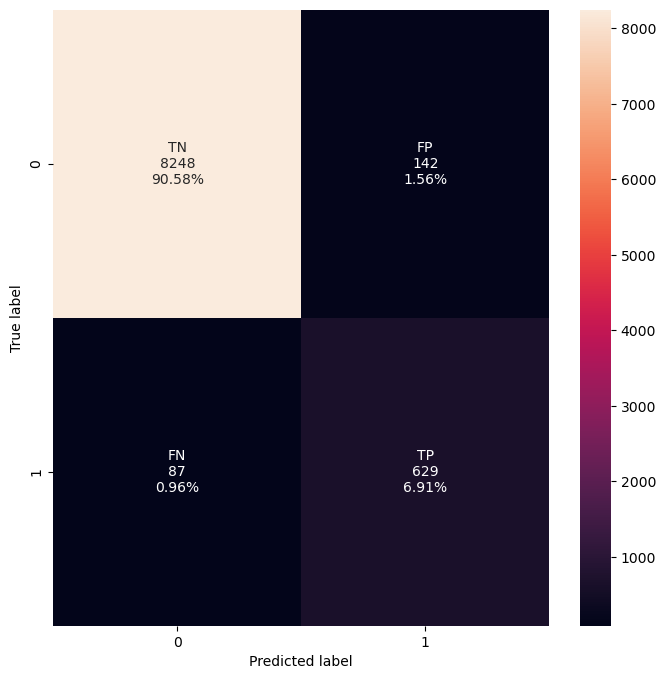

In [98]:
preds = model_training(DecisionTreeClassifier(random_state=42))
scores, conf_matrix = evaluate(preds, metrics)
plot_evaluation(scores, conf_matrix)

dt_pipeline = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

# Evaluate and append results
evaluate_model("Decision Tree", dt_pipeline)

Gaussian Naive Bayes

Accuracy: 0.9677135954315835
Precision: 0.6186770428015564
Recall: 1.0
F1 Score: 0.7644230769230769


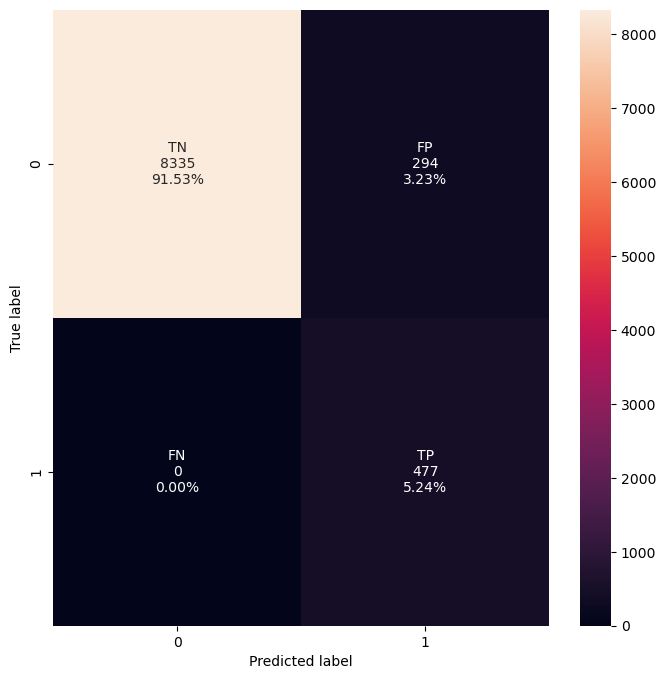

In [99]:
preds = model_training(GaussianNB())
scores, conf_matrix = evaluate(preds, metrics)
plot_evaluation(scores, conf_matrix)

gnb_pipeline = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", GaussianNB())
])

# Evaluate and append to results
evaluate_model("GaussianNB", gnb_pipeline)

Comparing model performance

In [100]:
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(results_df)

                 Model       AUC  Accuracy  Precision    Recall        F1
3           GaussianNB  0.994155  0.977048   1.000000  0.728923  0.843211
1  Logistic Regression  0.993364  0.951570   0.643979  0.957198  0.769953
0            KNN (k=4)  0.971273  0.968043   0.777136  0.872892  0.822236
2        Decision Tree  0.935030  0.969251   0.782509  0.881971  0.829268
